In [ ]:
!pip install -q sentence-transformers pandas numpy scikit-learn

In [1]:
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler


train_df = pd.read_csv("../data/student_emotion_dataset_80k_balanced.csv")
test_df = pd.read_csv("../data/student_emotion_dataset_test_20k_balanced.csv")


In [2]:
def add_history_features(df, history_counter=None):
    if history_counter is None:
        history_counter = defaultdict(int)
    history_counts = []
    for _, row in df.iterrows():
        key = f"{row['student_id']}_{row['subject']}"
        history_counts.append(history_counter[key])
        history_counter[key] += 1
    df['history_count'] = history_counts
    return df, history_counter

# Add to both train and test
train_df, history_counter = add_history_features(train_df)
test_df, _ = add_history_features(test_df, history_counter)

# Normalize history count
scaler = MinMaxScaler()
train_df['history_count_norm'] = scaler.fit_transform(train_df[['history_count']])
test_df['history_count_norm'] = scaler.transform(test_df[['history_count']])

In [3]:
import numpy as np

# Difficulty map
difficulty_score_map = {'beginner': 0.2, 'intermediate': 0.5, 'advanced': 0.8}
urgency_score_map = {'low': 0.0, 'medium': 0.5, 'high': 1.0}

def get_score(row):
    difficulty_score = difficulty_score_map.get(row['difficulty_level'], 0.5)
    urgency_score = urgency_score_map.get(row['urgency_level'], 0.0)
    experience_score = 1 - row['history_count_norm']

    # Weighted sum
    score = (
        0.4 * difficulty_score +
        0.4 * urgency_score +
        0.2 * experience_score +
        np.random.normal(0, 0.1)  # Add noise
    )
    return score

def classify_strategy(row):
    score = get_score(row)
    if score >= 0.65:
        return 'RAG'
    elif score <= 0.35:
        return 'CAG'
    else:
        return 'Both'

train_df['strategy_label'] = train_df.apply(classify_strategy, axis=1)
test_df['strategy_label'] = test_df.apply(classify_strategy, axis=1)


In [4]:
train_binary = train_df[train_df['strategy_label'] != 'Both']
test_binary = test_df[test_df['strategy_label'] != 'Both']

print("Training Label Distribution:")
print(train_binary['strategy_label'].value_counts())

print("\nTesting Label Distribution:")
print(test_binary['strategy_label'].value_counts())


Training Label Distribution:
strategy_label
CAG    26505
RAG    21632
Name: count, dtype: int64

Testing Label Distribution:
strategy_label
CAG    6662
RAG    5434
Name: count, dtype: int64


In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')


c:\Dave\Apps\miniconda3.9\envs\action_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [6]:
train_queries = train_binary['current_query'].astype(str).tolist()
test_queries = test_binary['current_query'].astype(str).tolist()

train_query_embeddings = model.encode(train_queries, show_progress_bar=True, batch_size=64)
test_query_embeddings = model.encode(test_queries, show_progress_bar=True, batch_size=64)


Batches: 100%|██████████| 189/189 [00:32<00:00,  5.83it/s]


In [7]:
import numpy as np

# Get numeric features
train_features = train_binary[['history_count_norm']].values
test_features = test_binary[['history_count_norm']].values

# Combine embeddings + numeric
X_train = np.hstack([train_query_embeddings, train_features])
X_test = np.hstack([test_query_embeddings, test_features])


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_binary['strategy_label'])
y_test = le.transform(test_binary['strategy_label'])

print("Classes:", le.classes_)


Classes: ['CAG' 'RAG']


In [9]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    alpha=0.001,
    max_iter=500,
    random_state=42
)

clf.fit(X_train, y_train)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=500,
              random_state=42)

Classification Report:

              precision    recall  f1-score   support

         CAG       0.94      0.97      0.96      6662
         RAG       0.96      0.93      0.95      5434

    accuracy                           0.95     12096
   macro avg       0.95      0.95      0.95     12096
weighted avg       0.95      0.95      0.95     12096



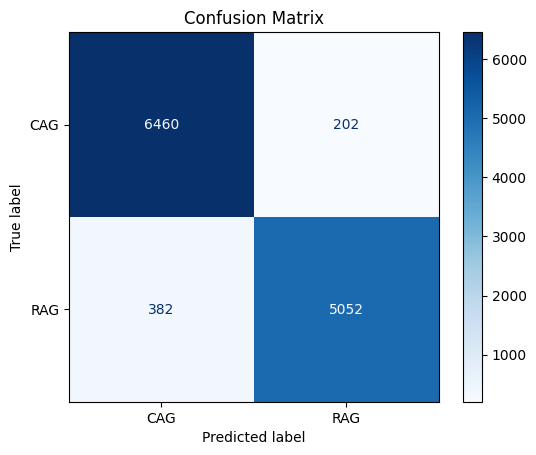

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


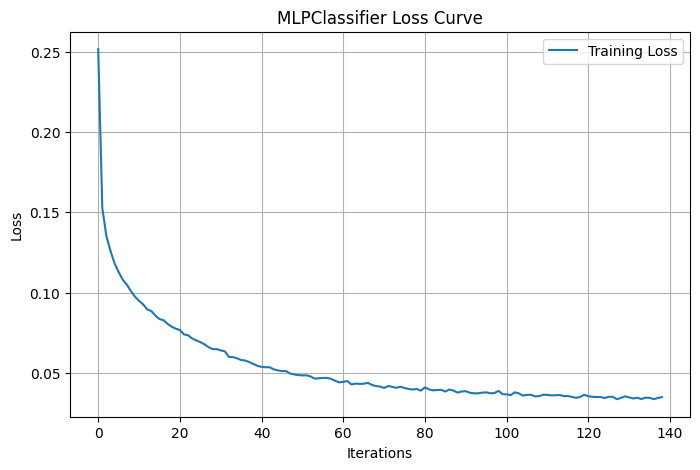

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(clf.loss_curve_, label='Training Loss')
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
